# Workshop: Introduction to pyJive

## Preliminaries

To start working, we add the main pyJive folder to `path` and make some imports. We use `autoreload` to ensure changes made to the code take effect without restarting the kernel.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import os
import sys

pyjivepath = 'pyjive/'
sys.path.append(pyjivepath)

if not os.path.isfile(pyjivepath + 'utils/proputils.py'):
    print('\n\n**pyjive cannot be found, adapt "pyjivepath" above or move notebook to appropriate folder**\n\n')
    raise Exception('pyjive not found')

from utils import proputils as pu
import main
from names import GlobNames as gn

Additionally, the necessary input files are are downloaded to the present path (if they are not there yet). 

In [2]:
import contextlib
from urllib.request import urlretrieve

def findfile(fname):
    url = "https://gitlab.tudelft.nl/cm/public/drive/-/raw/main/pyjiveintro/" + fname + "?inline=false"
    if not os.path.isfile(fname):
        print(f"Downloading {fname}...")
        urlretrieve(url, fname)

findfile("bar.mesh")
findfile("bar.pro")
findfile("solid.msh")
findfile("solid.pro")

## Case 1: a simple bar model (1D)

### Run the model as given

To start off, we run the following simple rod (or 'bar') problem:

<center>
  <figure>
    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/3elmbar.png" WIDTH=300>
  </figure>
</center>
    
We have a `bar.pro` file ready that describes this model. Take a look at it and try to see how things are being set up.
    
We now use pyJive to run it as is:

In [10]:
# read input file and store information in dict called 'props'
props = pu.parse_file('bar.pro')

# run the program with 'props' as input
globdat = main.jive(props)

Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading manual mesh file bar.mesh ...
InitModule: Creating node groups...
InitModule: Created group left with nodes [0]
InitModule: Created group right with nodes [3]
InitModule: Creating model...
Creating Line2Shape...
Running chain...
Running time step 0
End of execution


We can then use `globdat` to interact with model results. For instance, we can look at the nodal displacement values:

In [11]:
print(globdat[gn.STATE0])

[0. 1. 2. 3.]


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.1: Run code block and inspect results</b>   
    
Do the obtained values make sense? Check `bar.pro` and `bar.mesh` to see which values are used for the $EA$ of the bar and the length of the domain and derive a solution for this problem by hand.
</p>
</div>

### Change the model from the notebook

We can look at what `parse_file` read from `bar.pro`, make modifications and run the model again:

In [12]:
# overwrite one of the values in props
props['model']['bar']['EA'] = 1000

# run the program with the updated input
globdat = main.jive(props)

# print the result
print(globdat[gn.STATE0])

Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading manual mesh file bar.mesh ...
InitModule: Creating node groups...
InitModule: Created group left with nodes [0]
InitModule: Created group right with nodes [3]
InitModule: Creating model...
Creating Line2Shape...
Running chain...
Running time step 0
End of execution
[0.    0.001 0.002 0.003]


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.2: Modify/overwrite values and inspect results</b>   
  
In the code block above, one of the inputs is overwritten and the problem is solved again. 

- Do the new results make sense? 
    
Use the code block below to try it for yourself:

- Change the Dirichlet boundary condition on the left from $0$ to $1$
- Change the Neumann boundary condition on the right from $1$ to $10$
    
Can you achieve the same by changing the .pro file? 
</p>
</div>


Rather than inspecting the complete solution vector, we can make use of `DofSpace` to directly look at the displacement at a certain node, e.g. at the right-end node:

In [13]:
# get the index of the first node in nodegroup 'right' (there is only one node in the nodegroup in this case)
node = globdat[gn.NGROUPS]['right'][0]

# get the degree-of-freedom index of the displacement in x-direction at that node
dof = globdat[gn.DOFSPACE].get_dof(node,'dx')

# print the solution for the selected degree of freedom
print('Displacement of node',node,'with DOF index',dof,':',globdat[gn.STATE0][dof])

Displacement of node 3 with DOF index 3 : 0.0029999999999999996


### Inspect the flow of the program

The idea of working with pyJive in this course is not that you understand every detail of the code, but that you can get an overview of the flow of a finite element simulation and that you can see how the concepts that are discussed in class are translated to code. In different workshops we will point out different parts of the code and ask you to inspect them. 

The main model in the case analyzed above is the `barmodel`. 

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.3: Modify/overwrite values and inspect results</b>   

Find the file `barmodel.py` and the function `takeAction`. Use print statements to find out in which order the different actions are called. Answer the following questions
- Which action(s) are implemented in the `barmodel`? 
- Which action(s) are ignored?
- Which other models do you expect to act on the actions that `barmodel` ignores?

Look at the `get_matrix` function. You should recognize the code in this function as implementing the finite element stiffness matrix assembly for the bar problem:
- How many integration points are used for numerical integration of the stiffness matrix? Use print statements to confirm that the code follows the instructions from the input file.

</p>
</div>


In [14]:
# read input file and run program

props = pu.parse_file('bar.pro')
globdat = main.jive(props)

Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading manual mesh file bar.mesh ...
InitModule: Creating node groups...
InitModule: Created group left with nodes [0]
InitModule: Created group right with nodes [3]
InitModule: Creating model...
Creating Line2Shape...
Running chain...
Running time step 0
End of execution


## Case 2: simply supported beam (2D)

### Problem definition

In this notebook we model a beam with two-dimensional elastostatics. Consider the following beam:

<center><img src="https://raw.githubusercontent.com/fmeer/public-files/main/5123/beam.png" alt="beam" width="500"/></center>

We would like to model this with linear triangles using pyJive. You will start from the provided `solid.pro` property file, which uses the provided `SolidModel`. We first run the model with a point load at midspan and look at the deformations.



### Run the model with a point load

Use the provided `solid.pro` and `solid.msh` to run a 2D problem. Note that `solid.pro` also specifies a `ViewModule` to be created which will visualize the displacement field.

Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading mesh file solid.msh ...
InitModule: Creating node groups...
InitModule: Created group lb with nodes [0]
InitModule: Created group rb with nodes [1]
InitModule: Created group tm with nodes [3]
InitModule: Creating model...
Creating Tri3Shape...
Running chain...
Running time step 0


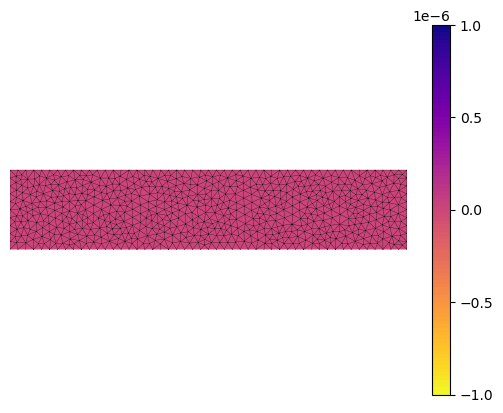

End of execution


In [15]:
# read input file and run program

props = pu.parse_file('solid.pro')
globdat = main.jive(props)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.1: Modify/overwrite inputs and inspect results</b>   

- Run the model as is and assert that there are no deformations
- Add a NeumannModel by extending the input in `solid.pro` or directly in `props` in order to add a point load to the model
- Compare the maximum displacement in the beam with the analytical solution $\Delta=\frac{FL^3}{48EI}$. Can you think of an explanation for the difference you see?


**TIP**: For checking the maximum displacement you can either look at the field plotted by the viewmodule or get the value directly from `globdat[gn.STATE0]` using `globdat[gn.DOFSPACE]`.
</p>
</div>

### Run the model with a body load

Now we **remove the point load**, and the goal becomes to run the model with a body force $\mathbf{b} = \rho\mathbf{g}=[0,-1]^\mathrm{T}$. The case to be solves is visualized as:

<center><img src="https://raw.githubusercontent.com/fmeer/public-files/main/5123/beam-body-force.png" alt="beam" width="500"/></center>



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.2: Run the model with a body load</b>   

We start from the properties stored in `solid.pro`. If you added the point load there, you will have to set it to zero again. We need to set up additional properties. The material already has a $\rho$ parameter, yet the previous analysis did not account for self weight. This is because `solidmodel.py` has a switch for evaluating body loads that was not set. 
    
- Look up in `solidmodel.py` how to switch on the gravity. 
    
- Now compare the **midpoint deflection** with the analytical solution for a beam with distributed load $\Delta=\frac{5qL^4}{384EI}$ 

</p>
</div>
    

Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading mesh file solid.msh ...
InitModule: Creating node groups...
InitModule: Created group lb with nodes [0]
InitModule: Created group rb with nodes [1]
InitModule: Created group tm with nodes [3]
InitModule: Creating model...
Creating Tri3Shape...
Running chain...
Running time step 0


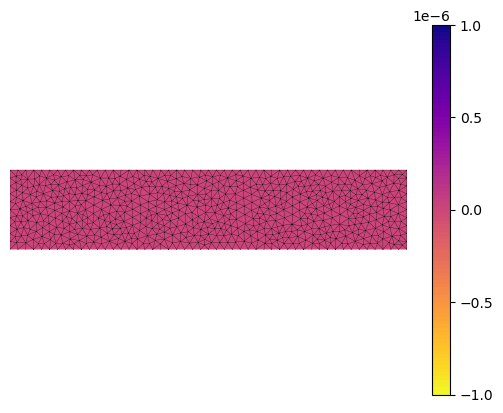

End of execution


In [16]:
# read input file and run program

props = pu.parse_file('solid.pro')
globdat = main.jive(props)